# Testing Zero Shot Super Resolution (ZSSR)



In [30]:
!pip install pyhdf h5py pytorch-ignite PyWavelets piqa -q

import PIL
import numpy as np
import sys
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.functional import interpolate
from torchvision import transforms
from torchvision.transforms import functional as ttf
import numbers
import cv2
from tqdm import tqdm
from pyhdf.SD import SD, SDC
from h5py import File as h5File
import pywt as pywt

from einops import rearrange
import matplotlib.pyplot as plt

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.metrics.regression import *
from ignite.utils import *

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

### Utilities loading

In [31]:
class TensorRandomRotationFromSequence(object):
    def __init__(self, degree):
        self.degrees = degrees

    @staticmethod
    def get_params(degrees):
        angle = np.random.choice(degrees)
        return angle
    def __call__(self, collapsed):
        angle = self.get_params(self.degrees)
        return ttf.rotate(collapsed, angle)

class RandomRotationFromSequence(object):
    """Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
    """

    def __init__(self, degrees):
        self.degrees = degrees

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.choice(degrees)
        return angle

    def __call__(self, data):
        """img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        angle = self.get_params(self.degrees)
        try: # as in original implementation
            hr, lr = data
            return ttf.rotate(hr, angle), ttf.rotate(lr, angle)
        except: # if you are providing a tensor
            return ttf.rotate(data, angle)

class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        hr, lr = data
        if random.random() < 0.5:
            return ttf.hflip(hr), ttf.hflip(lr)
        return hr, lr

class RandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a probability of 0.5."""

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
        """
        hr, lr = data
        if random.random() < 0.5:
            return ttf.vflip(hr), ttf.vflip(lr)
        return hr, lr

class RandomCrop(object):
    """Crop the given PIL Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
    """

    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    @staticmethod
    def get_params(data, output_size):
        """Get parameters for ``crop`` for a random crop.
        Args:
            img (PIL Image): Image to be cropped.
            output_size (tuple): Expected output size of the crop.
        Returns:
            tuple: params (i, j, h, w) to be passed to ``crop`` for random crop.
        """
        hr, lr = data
        _, _,h, w = hr.shape
        th, tw = output_size
        if w == tw or h == th:
            return 0, 0, h, w

        if w < tw or h < th:
            th, tw = h//2, w//2

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, data):
        """
        Args:
            img (PIL Image): Image to be cropped.
        Returns:
            PIL Image: Cropped image.
        """
        try:
            hr, lr = data
        except:
            hr = data[0, :,:,:].unsqueeze(0)
            lr = data[1, :,:,:].unsqueeze(0)

        if self.padding > 0:
            hr = ttf.pad(hr, self.padding)
            lr = ttf.pad(lr, self.padding)

        i, j, h, w = self.get_params(data, self.size)
        return ttf.crop(hr, i, j, h, w), ttf.crop(lr, i, j, h, w)

class ToTensor(object):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """

    def __call__(self, data):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        hr, lr = data
        return ttf.to_tensor(hr), ttf.to_tensor(lr)


def read_h5_temperature(filename):
    """ Return torch tensor"""
    #Open the H5 file in read mode
    with h5File(filename, 'r') as f:
        tmp = torch.Tensor(f["Temperature"]["Mean"]).unsqueeze(0)
        tmp = torch.where(tmp==-9999, tmp[tmp!=0].mean(), tmp)
        tmp = tmp * 0.01
        tmp = tmp / tmp.max()
        return tmp

def rescale_data(lr, hr):
    max_val = max(lr.max().item(), hr.max().item())
    return lr / max_val, hr / max_val

# General Utils
def adjust_learning_rate(optimizer, new_lr):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

### Evaluation metrics


In [32]:
from piqa import SSIM

class SSIMLoss(SSIM):
    @staticmethod
    def check_dim(x):
        _, c, _, _ = x.shape
        if c == 1:
            x = x.repeat(1,3,1,1)
        elif c == 2:
            x = x[:,0,:,:].unsqueeze(1).repeat(1,3,1,1)
        return x

    @staticmethod
    def cast_values(x):
        x = torch.where(x<0, 0.0, x)
        x = torch.where(x>1, 1.0, x)
        return x

    def forward(self, x, y):
        x = self.check_dim(self.cast_values(x))
        y = self.check_dim(self.cast_values(y))
        return 1. - super().forward(x, y)

class PSNR(nn.Module):
    def __init__(self):
        super(PSNR, self).__init__()
        self.name = "PSNR"
    def forward(self, x, y):
        mse = torch.mean((x - y) ** 2)
        return -(20 * torch.log10(1.0 / torch.sqrt(mse)))

ssim = SSIMLoss()
x = torch.rand((1,1,64,64))
print(ssim(x,x))

tensor(0.)


### Architectures loading

#### ZSSRnet
Reference

```Adapted From: https://github.com/jacobgil/pytorch-zssr (Apache License)  @ jacobgil ```


In [33]:
import torch
import torch.nn as nn

class ZSSRNet(nn.Module):
    def __init__(self, input_channels=1, out_channels=1, kernel_size=3, channels=64, ndepth=6):
        super(ZSSRNet, self).__init__()

        internalblocks = [nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding = "same", bias=True),
            nn.ReLU())
            for _ in range(ndepth)
        ]

        self.conv_i = nn.Sequential(
            nn.Conv2d(input_channels, channels, kernel_size, padding="same", bias=True),
            nn.ReLU())
        self.conv_m = nn.Sequential(*internalblocks)
        self.conv_f = nn.Conv2d(channels, out_channels, kernel_size, padding="same", bias=True)

    def forward(self, x):
        orig = x[:,0,:,:].unsqueeze(1).clone()
        x = self.conv_i(x)
        x = self.conv_m(x)
        x = self.conv_f(x)
        return x + orig

#### MRUNet
Reference
```
Adapted from: https://github.com/IMT-Project-LTS-SR/MRUNet-for-MODIS-super-resolution/blob/main/model.py
```

In [ ]:
import torch
import cv2
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
from torchvision.utils import save_image
from torchvision import transforms
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import os
import torch.nn.functional as F

from math import sqrt

import torch.nn.init as init

num = 64
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DoubleConv_Down(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv_Down, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, res_down=False):
        super(Down, self).__init__()
        self.res_down = res_down
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        if self.res_down:
            self.in_conv = nn.Conv2d(in_channels, in_channels, kernel_size=2, stride=2)
            self.mid_conv = DoubleConv(in_channels, in_channels)
            self.out_conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        if self.res_down:
            return self.out_conv(self.mid_conv((self.in_conv(x))) + self.in_conv(x))
        else:
            return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2],mode='reflect')
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        # self.conv = nn.Sequential(
        #     nn.Conv2d(in_channels, out_channels, kernel_size=1),
        #     nn.Sigmoid())

    def forward(self, x):
        return self.conv(x)

class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

class MRUNet(nn.Module):
    def __init__(self, n_channels=1, n_outchannels=1, res_down=False, n_resblocks=1,
                 padding_type="reflect", norm_layer=nn.BatchNorm2d, use_dropout=False,
                 use_bias=True, bilinear=False):
        super(MRUNet, self).__init__()
        self.n_channels = n_channels
        self.n_outchannels = n_outchannels
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)

        ### Encoder
        factor = 2 if bilinear else 1

        self.down1 = Down(64, 128, res_down=res_down)
        self.down2 = Down(128, 256, res_down=res_down)
        self.down3 = Down(256, 512, res_down=res_down)
        self.down4 = Down(512, 1024 // factor, res_down=res_down)

        ### Residual blocks
        resblocks = []
        for i in range(n_resblocks):
            resblocks += [ResnetBlock(1024 // factor, padding_type, norm_layer, use_dropout, use_bias)]
        self.resblocks = nn.Sequential(*resblocks)

        ### Decoder
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_outchannels)
        self.up = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.up_dc = DoubleConv(64, 64)
        self.drop = nn.Dropout(p=0.3)

    def forward(self, x):
        orig = x[:, 0, :, :].unsqueeze(1)
        x1 = self.inc(x) #64
        x2 = self.down1(x1) #128
        x3 = self.down2(x2) #256
        x4 = self.down3(x3) #512
        x5 = self.down4(x4) #1024

        x5 = self.resblocks(x5)

        xp1 = self.up1(x5, x4) #512
        xp2 = self.up2(xp1, x3) #256
        xp3 = self.up3(xp2, x2) #128
        xp4 = self.up4(xp3, x1) #64
        # x = self.up(x)
        # x = self.up_dc(x)
        out = self.outc(xp4) + orig
        return out

# Sampler Implementation

### DataSampler, tensor implementation

In [ ]:
class DataSamplerSingle:
    def __init__(self, img, sr_factor, crop_size):
        """ img must be a torch tensor """

        self.c, self.h, self.w = img.shape
        self.img = img.reshape(1, self.c, self.h, self.w)
        self.sr_factor = sr_factor
        self.pairs = self.create_hr_lr_pairs()
        self.crop_size = crop_size

        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                            for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomCrop((self.crop_size, self.crop_size),
                                  pad_if_needed=True) ])

        self.degrees = [0., 90., 180., 270.]

    def rotate(self, tensor):
        angle = np.random.choice(self.degrees)
        return ttf.rotate(tensor, angle)

    def create_hr_lr_pairs(self):
        smaller_side, larger_side = min(self.h,self.w), max(self.h,self.w)
        factors = []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                factors.append(zoom)

        pairs = []
        for zoom in factors:
            hr = interpolate(self.img, scale_factor=zoom, mode="bicubic", antialias=True)
            lr = interpolate(hr, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            pairs.append((hr, lr))

        return pairs

    def force_patch_size(self, tensor):
        _, _, h, w = tensor.shape
        target_crop = (self.crop_size, self.crop_size)
        if (h, w) != target_crop :
            # Consider to use nearest
            tensor = interpolate(tensor, size=target_crop, mode="bicubic", antialias=True)
        return tensor

    def generate_data(self):
        while True:
            hr, lr = random.choices(self.pairs, weights=self.pair_probabilities, k=1)[0]
            pair = torch.cat([hr, lr], 0)
            pair = self.transform(pair)
            pair = self.rotate(pair)
            pair = self.force_patch_size(pair)
            hr_tensor = pair[0, :, :, :].unsqueeze(0)
            lr_tensor = pair[1, :, :, :].unsqueeze(0)
            yield hr_tensor, lr_tensor


In [ ]:
filenameLR = "AG1km.v003.45.006.0010.h5"
filenameHR = "AG100.v003.45.006.0001.h5"
img = read_h5_temperature(filenameLR)

sampler = DataSamplerSingle(img, sr_factor=10, crop_size=64)

c = 0
while c<10:
    hr, lr = sampler.generate_data().__next__()
    print(hr.shape, lr.shape)
    _,axs = plt.subplots(1, 2, figsize=(8,5))
    axs[0].imshow((hr.squeeze()))
    axs[1].imshow((lr.squeeze()))
    c+=1

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'AG1km.v003.45.006.0010.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Showing intermediate scale factor degradation.

In [ ]:
for hr, lr in sampler.pairs:
    _, axs = plt.subplots(1,2,figsize=(8,4))
    axs[0].imshow(ttf.to_pil_image(hr.squeeze())); axs[0].set_title(hr.shape)
    axs[1].imshow(ttf.to_pil_image(lr.squeeze())); axs[1].set_title(lr.shape)
    plt.show()

### DataSampler, Batch implementation
The present implementation enables to yield batches of samples that undergo augmentation via default

In [ ]:
class DataSamplerBatch:
    def __init__(self, img, sr_factor, crop_size, batch_size):
        """ img must be a torch tensor """

        self.c, self.h, self.w = img.shape
        self.img = img.reshape(1, self.c, self.h, self.w)
        self.sr_factor = sr_factor
        self.crop_size = crop_size
        self.batch_size = batch_size
        self.pairs = self.create_hr_lr_pairs()

        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                            for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomCrop((self.crop_size, self.crop_size),
                                  pad_if_needed=True)
             ])

        self.degrees = [0., 90., 180., 270.]

    def rotate(self, tensor):
        angle = np.random.choice(self.degrees)
        return ttf.rotate(tensor, angle)

    def create_hr_lr_pairs(self):
        smaller_side, larger_side = min(self.h,self.w), max(self.h,self.w)
        self.factors, pairs = [], []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                self.factors.append(zoom)
        for zoom in self.factors:
            hr = interpolate(self.img, scale_factor=zoom, mode="bicubic", antialias=True)
            lr = interpolate(hr, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            pairs.append((hr, lr))
        return pairs

    def force_patch_size(self, tensor):
        _, _, h, w = tensor.shape
        target_crop = (self.crop_size, self.crop_size)
        if (h, w) != target_crop :
            # Consider to use nearest
            tensor = interpolate(tensor, size=target_crop, mode="bicubic", antialias=True)
        return tensor

    def generate_data(self):
        """ Return batch of sampled data """
        while True:
            # List of pairs
            batch = [] # or torch .zeros
            pairs = [torch.cat([hr, lr], 0) for hr, lr in \
                     random.choices(self.pairs, weights=self.pair_probabilities,
                     k=self.batch_size)]

            for pair in pairs:
                pair = self.transform(pair)
                pair = self.rotate(pair)
                pair = self.force_patch_size(pair)
                batch.append(pair.unsqueeze(0))

            batch = torch.cat(batch, 0)
            hr_tensor = batch[:, 0, :, :, :]
            lr_tensor = batch[:, 1, :, :, :]
            yield hr_tensor, lr_tensor

### DataSampler, Batch implementation, High Frequency


In [ ]:
class DataSamplerBatchHF():
    def __init__(self, img, sr_factor, crop_size, batch_size, crop_only=True):
        """ img must be a torch tensor """

        self.c, self.h, self.w = img.shape
        self.img = img.reshape(1, self.c, self.h, self.w)
        self.hfimg = self.get_hf_components(self.img)
        self.img = torch.cat([self.img, self.hfimg], 1)

        self.sr_factor = sr_factor
        self.crop_size = crop_size
        self.batch_size = batch_size
        self.crop_only = crop_only

        self.pairs = self.create_hr_lr_pairs()


        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                            for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

        if self.crop_only:
            self.transform = transforms.Compose([
                transforms.RandomCrop((self.crop_size, self.crop_size),
                                       pad_if_needed=True)
                ])
        else:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomCrop((self.crop_size, self.crop_size),
                                       pad_if_needed=True)
                ])

        self.degrees = [0., 90., 180., 270.]

    @staticmethod
    def get_hf_components(x):
        """ Args:
            x: (torch.Tensor) of dim (_, _, h, w)
        """
        _, c, h, w = x.shape
        x = F.interpolate(x, scale_factor=2, mode="bicubic", antialias=True)
        _, (cH, cV, cD) = pywt.wavedec2(x, 'db1', level=1)
        csum = torch.abs(torch.Tensor([cH, cV, cD]).sum(0))
        return csum.view(1, 1, csum.shape[-2], csum.shape[-1])

    def rotate(self, tensor):
        angle = np.random.choice(self.degrees)
        return ttf.rotate(tensor, angle)

    def create_hr_lr_pairs(self):
        smaller_side, larger_side = min(self.h,self.w), max(self.h,self.w)
        self.factors, pairs = [], []
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side*zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                self.factors.append(zoom)
        for zoom in self.factors:
            hr = F.interpolate(self.img, scale_factor=zoom, mode="bicubic", antialias=True)
            hr_only = hr[:, 0, :, :].unsqueeze(0)
            hfmap   = hr[:, 1, :, :].unsqueeze(0)
            lr = F.interpolate(hr_only, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = F.interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            lr = torch.cat([lr, hfmap], 1)
            pairs.append((hr, lr))
        return pairs

    def force_patch_size(self, tensor):
        _, _, h, w = tensor.shape
        target_crop = (self.crop_size, self.crop_size)
        if (h, w) != target_crop :
            # Consider to use nearest
            tensor = F.interpolate(tensor, size=target_crop, mode="bicubic", antialias=True)
        return tensor

    def generate_data(self):
        """ Return batch of sampled data """
        while True:
            # List of pairs
            batch = []
            pairs = [torch.cat([hr, lr], 0) for hr, lr in \
                     random.choices(self.pairs, weights=self.pair_probabilities,
                     k=self.batch_size)]

            for pair in pairs:
                pair = self.transform(pair)
                pair = self.rotate(pair) if not self.crop_only else pair
                pair = self.force_patch_size(pair)
                batch.append(pair.unsqueeze(0))

            batch = torch.cat(batch, 0)
            hr_tensor = batch[:, 0, :, :, :]
            lr_tensor = batch[:, 1, :, :, :]
            yield hr_tensor, lr_tensor

batch_size = 8
crop_size  = 64
sr_factor  = 10

filenameLR = "AG1km.v003.45.006.0010.h5"
filenameHR = "AG100.v003.45.006.0001.h5"
img = read_h5_temperature(filenameLR)

sampler = DataSamplerBatchHF(img, sr_factor, crop_size, batch_size, crop_only=False)

In [ ]:
n = 16
crop_size=24
transform = transforms.Compose([transforms.RandomCrop((crop_size, crop_size),
                                       pad_if_needed=True)])
pair = sampler.pairs[0]
hr, lr = pair
pair = torch.cat([hr, lr], 0).unsqueeze(0).repeat(n,1,1,1,1)
batch = []
for i in range(n):
    curr_pair = pair[i, :, :, :, :]
    curr_pair = transform(curr_pair).unsqueeze(0)
    batch.append(curr_pair)
batch = torch.cat(batch, 0)

hr_tensor = batch[:, 0, :, :, :]
lr_tensor = batch[:, 1, :, :, :]
hr_tensor.shape

### Opt implementation

In [ ]:
class DataSampler(object):
    def __init__(self, img, sr_factor, crop_size, batch_size, crop_only=False):
        """ img must be a torch tensor """

        self.c, self.h, self.w = img.shape
        self.img = img.reshape(1, self.c, self.h, self.w).to(DEVICE)
        self.sr_factor = sr_factor
        self.crop_size = crop_size
        self.batch_size = batch_size
        self.crop_only  = crop_only
        self.factors = []
        self.pairs = []
        self.create_intermediate_factors()

        if self.crop_only:
            self.transform = transforms.Compose([
                transforms.RandomCrop((self.crop_size, self.crop_size),
                                       pad_if_needed=True)
                ])
        else:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomCrop((self.crop_size, self.crop_size),
                                       pad_if_needed=True)
                ])
        self.degrees = [0., 90., 180., 270.]

    def create_intermediate_factors(self):
        smaller_side, larger_side = min(self.h,self.w), max(self.h,self.w)
        for i in range(smaller_side//5, smaller_side+1):
            downsampled_smaller_side = i
            zoom = float(downsampled_smaller_side)/smaller_side
            downsampled_larger_side = round(larger_side * zoom)
            if downsampled_smaller_side%self.sr_factor==0 and \
                downsampled_larger_side%self.sr_factor==0:
                self.factors.append(zoom)

    def rotate(self, tensor):
        angle = np.random.choice(self.degrees)
        return ttf.rotate(tensor, angle)

    def force_patch_size(self, tensor):
        _, _, h, w = tensor.shape
        target_crop = (self.crop_size, self.crop_size)
        if (h, w) != target_crop :
            # Consider to use nearest
            tensor = interpolate(tensor, size=target_crop, mode="bicubic", antialias=True)
        return tensor

    def generate_data(self):
        """ Return batch of sampled data """
        while True:
            # List of pairs
            batch = []
            pairs = [torch.cat([hr, lr], 0) for hr, lr in \
                     random.choices(self.pairs, weights=self.pair_probabilities,
                     k=self.batch_size)]

            for pair in pairs:
                pair = self.transform(pair)
                pair = self.rotate(pair) if not self.crop_only else pair
                pair = self.force_patch_size(pair)
                batch.append(pair.unsqueeze(0))

            batch = torch.cat(batch, 0)
            hr_tensor = batch[:, 0, :, :, :]
            lr_tensor = batch[:, 1, :, :, :]
            yield hr_tensor, lr_tensor


class DataSamplerBatch(DataSampler):

    def __init__(self, img, sr_factor, crop_size, batch_size, crop_only):
        super().__init__(img, sr_factor, crop_size, batch_size, crop_only)

        # generate intermediate scale factors pairs
        self.create_hr_lr_pairs()
        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

    def create_hr_lr_pairs(self):
        self.pairs = []
        for zoom in self.factors:
            hr = interpolate(self.img, scale_factor=zoom, mode="bicubic", antialias=True)
            lr = interpolate(hr, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            self.pairs.append((hr, lr))


class DataSamplerBatchHF(DataSampler):
    def __init__(self, img, sr_factor, crop_size, batch_size, crop_only=False):
        super().__init__(img, sr_factor, crop_size, batch_size, crop_only)

        # Appending HF components at channel dimension
        self.hfimg = self.get_hf_components(self.img).to(DEVICE)
        self.img = torch.cat([self.img, self.hfimg], 1).to(DEVICE)

        # generate intermediate scale factors pairs
        self.create_hr_lr_pairs()
        sizes = np.float32([hr.shape[-2]*hr.shape[-1] / float(self.h * self.w) \
                for hr, _ in self.pairs])
        self.pair_probabilities = sizes / np.sum(sizes)

    @staticmethod
    def get_hf_components(x):
        """ Args: x: (torch.Tensor) of dim (_, _, h, w)
        """
        tmp = x.clone()
        _, _, h, w = x.shape
        x = F.interpolate(tmp.detach().cpu(), scale_factor=2, mode="bicubic", antialias=True)
        _, (cH, cV, cD) = pywt.wavedec2(x, 'db1', level=1)
        csum = torch.abs(torch.Tensor([cH, cV, cD]).sum(0))
        return csum.view(1, 1, csum.shape[-2], csum.shape[-1])

    def create_hr_lr_pairs(self):
        self.pairs = []
        for zoom in self.factors:
            hr = F.interpolate(self.img, scale_factor=zoom, mode="bicubic", antialias=True)
            hr_only = hr[:, 0, :, :].unsqueeze(0)
            hfmap   = hr[:, 1, :, :].unsqueeze(0)
            lr = F.interpolate(hr_only, scale_factor=1/self.sr_factor, mode="bicubic", antialias=True)
            lr = F.interpolate(lr, scale_factor=self.sr_factor, mode="bicubic", antialias=True)
            lr = torch.cat([lr, hfmap], 1)
            self.pairs.append((hr, lr))


#### Intermediate SF dataset
Adapting a customised Dataset object that draws augmentation over intermediate scaled LR images.

In [ ]:
class IntermediateDataset(Dataset):
    def __init__(self, n, pair, full_size, transform):
        """ Args:
            n: (int) amount of child degradated images to be drawn from the curr pair
            pair: (tuple) of hr, lr tensors
        """
        self.n = n
        self.pair = pair
        self.hr, self.lr = self.pair
        _, self.c, _, _ = self.hr.shape
        self.full_size = full_size
        self.transform = transform

        # Initialise empty dataset to be scanned
        self.hr_tensor, self.lr_tensor = self.draw_subset()
        self.hr_tensor = self.hr_tensor.to(DEVICE)
        self.lr_tensor = self.lr_tensor.to(DEVICE)

    @staticmethod
    def force_patch_size(tensor, outdim):
        _, _, h, w = tensor.shape
        return interpolate(tensor, size=(outdim, outdim), mode="bicubic",
                 antialias=True) if (h, w) != (outdim, outdim) else tensor

    def draw_subset(self):
        # from tuple to tensor of dim (n, 2, c, h, w)
        batch = []
        pair = torch.cat([self.hr, self.lr], 0).unsqueeze(0).repeat(self.n, 1, 1, 1, 1)

        for i in range(self.n):
            curr_pair = pair[i, :, :, :, :]       # now on dim (2, c, h, w)
            curr_pair = self.force_patch_size(curr_pair, self.full_size)
            curr_pair = self.transform(curr_pair) # now on dim (2, c, h, w)
            batch.append(curr_pair.unsqueeze(0))  # now on dim (1, 2, c, h, w)
        batch = torch.cat(batch, 0)

        hr_tensor = batch[:, 0, :, :, :] # to dim (n, c, h, w)
        lr_tensor = batch[:, 1, :, :, :] # to dim (n, c, h, w)
        return hr_tensor, lr_tensor

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return self.hr_tensor[idx,:,:,:], self.lr_tensor[idx,:,:,:]

# test
full_size  = 100
crop_size  = 64
batch_size = 1
transf  = transforms.Compose([transforms.RandomCrop((crop_size, crop_size), pad_if_needed=True)])
sampler = DataSamplerBatchHF(img, sr_factor=10, crop_size=crop_size, batch_size=batch_size, crop_only=False)

for j in range(0, len(sampler.pairs)):
    ids = IntermediateDataset(20, sampler.pairs[j], full_size, transf)
    dl  = torch.utils.data.DataLoader(ids, batch_size=batch_size, shuffle=False)
    hr, lr = iter(dl).__next__()
    for i in range(batch_size):
        _,axs = plt.subplots(1, 4, figsize=(15,8))
        axs[0].imshow(hr[i, 0, :, :].detach().cpu().squeeze())
        axs[1].imshow(hr[i, 1, :, :].detach().cpu().squeeze(), cmap="gray")
        axs[2].imshow(lr[i, 0, :, :].detach().cpu().squeeze())
        axs[3].imshow(lr[i, 1, :, :].detach().cpu().squeeze(), cmap="gray")

Displaying intermediate factor pairs.

In [ ]:
for i, (hr, lr) in enumerate(sampler.pairs):
    _, axs = plt.subplots(1, 3, figsize=(10,3.8))
    l, h, hf = lr[:, 0, :, :].squeeze(), hr[:, 0, :, :].squeeze(), hr[:, 1, :, :].squeeze()
    axs[0].imshow(l.detach().cpu()); axs[0].set_title(f"LR (bicubic degradation)")
    axs[1].imshow(h.detach().cpu()); axs[1].set_title(f"HR")
    axs[2].imshow(hf.detach().cpu(), cmap="gray"); axs[2].set_title("HF components")
    plt.suptitle(f"Intermediate Scale-factor = {sampler.factors[i]}\n dim = {l.shape}")

Testing batch loading module.

In [ ]:
hr, lr = iter(sampler.generate_data()).__next__()
print(hr.shape, lr.shape)

for i in range(batch_size):
    _, axs = plt.subplots(1, 3, figsize=(12,6))
    axs[0].imshow(lr[i, 0, :, :].detach().cpu().squeeze())
    axs[1].imshow(hr[i, 0, :, :].detach().cpu().squeeze())
    axs[2].imshow(hr[i, 1, :, :].detach().cpu().squeeze(), cmap="gray")

# Self-supervised training

### Loss initialisation

In [ ]:
class SSIMLoss(SSIM):
    @staticmethod
    def check_dim(x):
        _, c, _, _ = x.shape
        if c == 1:
            x = x.repeat(1,3,1,1)
        elif c == 2:
            x = x[:,0,:,:].unsqueeze(1).repeat(1,3,1,1)
        return x

    @staticmethod
    def cast_values(x):
        x = torch.where(x<0, 0.0, x)
        x = torch.where(x>1, 1.0, x)
        return x

    def forward(self, x, y):
        x = self.check_dim(self.cast_values(x))
        y = self.check_dim(self.cast_values(y))
        return 1. - super().forward(x, y)

class ZeroShotLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1   = torch.nn.L1Loss()
        self.ssim = SSIMLoss()
    def forward(self, x, y):
        return self.l1(x, y) + self.ssim(x, y)

In [ ]:
def train(model, img, ground_truth, sampler, sr_factor, num_iter, learning_rate,
          crop_size, reduce_epoch=1000, reduce_sf=0.1):
    """ Train with random sampling image generator
    """
    loss_function = ZeroShotLoss().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    img_up = interpolate(sampler.img, scale_factor=sr_factor, mode="bicubic", antialias=True)
    img_up = img_up.to(DEVICE)
    ground_truth = ground_truth.to(DEVICE)

    cache_train = torch.zeros(num_iter)
    cache_eval  = torch.zeros(num_iter)
    progress_bar = tqdm(range(num_iter), total=num_iter)
    for iteration in progress_bar:

        model.train()
        hr, lr = sampler.generate_data().__next__()
        lr, hr = lr.to(DEVICE), hr.to(DEVICE)

        # Residual mapping (if not implemented by default)
        output = model(lr)
        error  = loss_function(output, hr)
        error.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Eval performance
        model.eval()
        with torch.no_grad():
            inference = model(img_up)
            error_eval = loss_function(inference, ground_truth)

        # Save logs
        cache_train[iteration] = error.item()
        cache_eval[iteration] = error_eval.item()
        progress_bar.set_postfix_str(f"Iteration: {iteration+1}/{num_iter} lr: {learning_rate} Loss «{(error.item()):.10f}»")

        # Adjust learning rate
        if iteration > 0 and iteration % reduce_epoch == 0:
            learning_rate = learning_rate * reduce_sf
            adjust_learning_rate(optimizer, new_lr=learning_rate)
            print("\nLearning rate reduced to {lr}".format(lr=learning_rate) )

    print("Done training.")
    return {"train":cache_train, "eval":cache_eval}


def train_dl(model, img, ground_truth, dataloader, sr_factor, num_iter, learning_rate,
             crop_size, reduce_epoch=1000, reduce_sf=0.1):
    """ Train with random sampling image generator
    """
    loss_function = ZeroShotLoss().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    img_up = interpolate(sampler.img, scale_factor=sr_factor, mode="bicubic", antialias=True)
    img_up = img_up.to(DEVICE)
    ground_truth = ground_truth.to(DEVICE)

    cache_train = torch.zeros(num_iter)
    cache_eval  = torch.zeros(num_iter)
    progress_bar = tqdm(range(num_iter), total=num_iter)
    for iteration in progress_bar:

        model.train()
        for hr, lr in dataloader:
            lr, hr = lr.to(DEVICE), hr.to(DEVICE)
            output = model(lr)
            error  = loss_function(output, hr)
            error.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Eval performance
        model.eval()
        with torch.no_grad():
            inference = model(img_up)
            error_eval = loss_function(inference, ground_truth)

        # Save logs
        cache_train[iteration] = error.item()
        cache_eval[iteration] = error_eval.item()
        progress_bar.set_postfix_str(f"Iteration: {iteration+1}/{num_iter} lr: {learning_rate} Loss «{(error.item()):.10f}»")

        # Adjust learning rate
        if iteration > 0 and iteration % reduce_epoch == 0:
            learning_rate = learning_rate * reduce_sf
            adjust_learning_rate(optimizer, new_lr=learning_rate)
            print("\nLearning rate reduced to {lr}".format(lr=learning_rate) )

    print("Done training.")
    return {"train":cache_train, "eval":cache_eval}


def train_prog(model, img, ground_truth, sampler, sr_factor, num_iter, num_items,
               learning_rate, crop_size, batch_size, reduce_epoch=1000,
               reduce_sf=0.1):
    """ Progressively enhance intermediate scale factor
    """
    loss_function = ZeroShotLoss().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    transf  = transforms.Compose([transforms.RandomCrop((crop_size, crop_size), pad_if_needed=True)])

    img_up = interpolate(sampler.img, scale_factor=sr_factor, mode="bicubic", antialias=True)
    img_up = img_up.to(DEVICE)
    ground_truth = ground_truth.to(DEVICE)

    sampler_sub_steps = len(sampler.pairs)
    tot_iters = num_iter*sampler_sub_steps
    cache_train, cache_eval = [], []

    # loop over substeps
    for sub_step in reversed(range(sampler_sub_steps)):
        print("Now on {} substeps forward.".format(sub_step))

        # Initialise the dataset
        ids = IntermediateDataset(num_items, sampler.pairs[sub_step], full_size=100, transform=transf)
        dataloader = torch.utils.data.DataLoader(ids, batch_size, shuffle=False)
        progress_bar = tqdm(range(num_iter), total=num_iter)
        for iteration in progress_bar:
            model.train()
            for hr, lr in dataloader:
                lr, hr = lr.to(DEVICE), hr.to(DEVICE)
                output = model(lr)
                error  = loss_function(output, hr)
                error.backward()
                optimizer.step()
                optimizer.zero_grad()
            progress_bar.set_postfix_str(f"Iteration: {iteration+1}/{num_iter} lr: {learning_rate} Loss «{(error.item()):.10f}»")

            # Eval performance
            model.eval()
            with torch.no_grad():
                inference = model(img_up)
                error_eval = loss_function(inference, ground_truth)

            # Save logs
            cache_train.append(error.item())
            cache_eval.append(error_eval.item())

        # Adjust learning rate
        #if iteration > 0 and iteration % reduce_epoch == 0:
        #    learning_rate = learning_rate * reduce_sf
        #    adjust_learning_rate(optimizer, new_lr=learning_rate)
        #    print("\nLearning rate reduced to {lr}".format(lr=learning_rate) )

    print("Done training.")
    return {"train":cache_train, "eval":cache_eval}



def test(model, img, sr_factor):
    """ Perform ZS SR considering a new SR factor:
    Args:
        model: (torch.nn.Module) currently self-supervised trained model
        img: (torch.Tensor)
        sr_factor: (int)
    Return:
        SR inference, original img (bicubic upsampled)
    """

    img_up = img.unsqueeze(0) if len(img.shape) < 4 else img
    img_up = interpolate(img_up, scale_factor=sr_factor, mode="bicubic", antialias=True)\
             .to(DEVICE)

    model.eval()
    with torch.no_grad():
        inference = model(img_up)
    return inference, img_up[:, 0, :, :].unsqueeze(1)

Now on 8 substeps forward.


100%|██████████| 5/5 [00:02<00:00,  1.93it/s, Iteration: 5/5 lr: 0.0001 Loss «0.2469948232»]


Now on 7 substeps forward.


100%|██████████| 5/5 [00:02<00:00,  1.94it/s, Iteration: 5/5 lr: 0.0001 Loss «0.1985159367»]


Now on 6 substeps forward.


100%|██████████| 5/5 [00:02<00:00,  1.94it/s, Iteration: 5/5 lr: 0.0001 Loss «0.1871439815»]


Now on 5 substeps forward.


100%|██████████| 5/5 [00:02<00:00,  1.93it/s, Iteration: 5/5 lr: 0.0001 Loss «0.1712981462»]


Now on 4 substeps forward.


100%|██████████| 5/5 [00:02<00:00,  1.94it/s, Iteration: 5/5 lr: 0.0001 Loss «0.1545855850»]


Now on 3 substeps forward.


100%|██████████| 5/5 [00:02<00:00,  1.93it/s, Iteration: 5/5 lr: 0.0001 Loss «0.1287415177»]


Now on 2 substeps forward.


100%|██████████| 5/5 [00:02<00:00,  1.93it/s, Iteration: 5/5 lr: 0.0001 Loss «0.1033415869»]


Now on 1 substeps forward.


100%|██████████| 5/5 [00:02<00:00,  1.92it/s, Iteration: 5/5 lr: 0.0001 Loss «0.0739489794»]


Now on 0 substeps forward.


100%|██████████| 5/5 [00:02<00:00,  1.87it/s, Iteration: 5/5 lr: 0.0001 Loss «0.0427473560»]


Done training.
Bicubic - Loss: 0.105868,
                    MAE: 0.028792,
                    PSNR: 30.145630,
                    SSIM: 0.922924
   ZSSR - Loss: 0.107615,
                    MAE: 0.030529,
                    PSNR: 29.694643,
                    SSIM: 0.922914


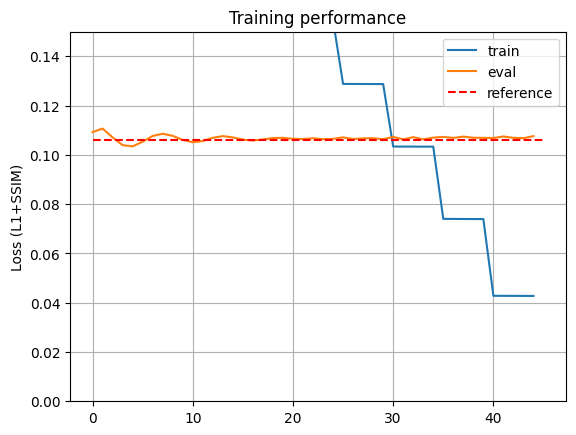

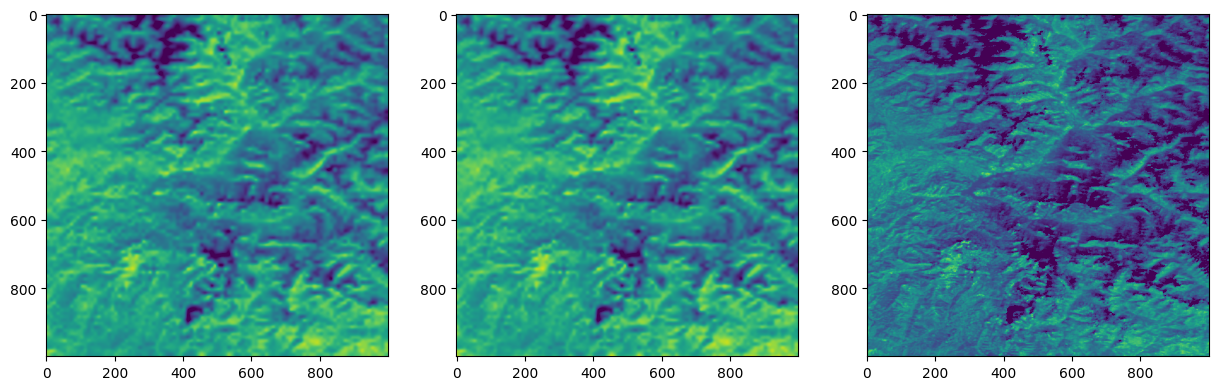

In [ ]:
CUDA_LAUNCH_BLOCKING=1
UP_SCALE   = 10
NUM_ITER   = 5
LEARN_RATE = 1e-4
CROP_SIZE  = 100
BATCH_SIZE = 64
DL_ITEMS   = 100

mae  = torch.nn.L1Loss()
ssim = SSIMLoss().to(DEVICE)
psnr = PSNR().to(DEVICE)
loss_function = ZeroShotLoss().to(DEVICE)

filenameLR = "AG1km.v003.45.006.0010.h5"
filanameHR = "AG100.v003.45.006.0001.h5"
ground_truth = read_h5_temperature(filanameHR).unsqueeze(0).to(DEVICE)
img          = read_h5_temperature(filenameLR).to(DEVICE)
llim, ulim   = (img.mean()-3*img.std()).item(), (img.mean()+3*img.std()).item()
channels = 1

# initialise sampler
transf  = transforms.Compose([transforms.RandomCrop((crop_size, crop_size), pad_if_needed=True)])
sampler = DataSamplerBatch(img, UP_SCALE, CROP_SIZE, BATCH_SIZE, crop_only=True)
ids     = IntermediateDataset(DL_ITEMS, sampler.pairs[0], full_size=100, transform=transf)
dataloader = torch.utils.data.DataLoader(ids, batch_size=BATCH_SIZE, shuffle=False)

# ZSSRNet (e2000, lr1e-5, cs64, bs16)
model  = ZSSRNet(input_channels=channels, out_channels=1, kernel_size=3, channels=64, ndepth=6).to(DEVICE)
#model = MRUNet(n_channels=channels, n_outchannels=1, n_resblocks=2).to(DEVICE)

#history = train(model, img, ground_truth, sampler,
#                sr_factor=UP_SCALE,
#                num_iter=NUM_ITER,
#                learning_rate=LEARN_RATE,
#                crop_size=CROP_SIZE,
#                reduce_epoch=int(NUM_ITER*0.75),
#                reduce_sf=0.1)
#history = train_dl(model, img, ground_truth, dataloader,
#                sr_factor=UP_SCALE,
#                num_iter=NUM_ITER,
#                learning_rate=LEARN_RATE,
#                crop_size=CROP_SIZE,
#                reduce_epoch=int(NUM_ITER*0.75),
#                reduce_sf=0.1)
history = train_prog(model, img, ground_truth, sampler,
                sr_factor=UP_SCALE,
                num_iter=NUM_ITER,
                num_items=DL_ITEMS,
                learning_rate=LEARN_RATE,
                crop_size=CROP_SIZE,
                batch_size=BATCH_SIZE,
                reduce_epoch=int(NUM_ITER*0.75),
                reduce_sf=0.1)


srimg, img_up  = test(model, img, sr_factor=UP_SCALE)
reference_loss = loss_function(img_up, ground_truth).detach().cpu().item()

# Print performance
print(f"""Bicubic - Loss: {loss_function(img_up, ground_truth):.6f},
                    MAE: {mae(img_up, ground_truth):.6f},
                    PSNR: {-psnr(img_up, ground_truth):.6f},
                    SSIM: {1-ssim(img_up, ground_truth):.6f}""")
print(f"""   ZSSR - Loss: {loss_function(srimg, ground_truth):.6f},
                    MAE: {mae(srimg, ground_truth):.6f},
                    PSNR: {-psnr(srimg, ground_truth):.6f},
                    SSIM: {1-ssim(srimg, ground_truth):.6f}""")

# Plot
plt.plot(history["train"], label="train");
plt.plot(history["eval"], label="eval");
plt.hlines(reference_loss, 0, len(history["train"]), colors="red", linestyle="dashed", label="reference")
plt.title("Training performance")
plt.ylabel("Loss (L1+SSIM)")
plt.ylim((0,0.15)); plt.legend(); plt.grid(); plt.show()
_, axs = plt.subplots(1, 3, figsize=(15, 10))
for i,item in enumerate((img_up, srimg, ground_truth)):
    axs[i].imshow(item.cpu().squeeze(), vmin=llim, vmax=ulim)
plt.show()

# High Frequency guided raining

### Loss initialisation




In [ ]:
class SSIMLoss(SSIM):
    @staticmethod
    def check_dim(x):
        _, c, _, _ = x.shape
        if c == 1:
            x = x.repeat(1,3,1,1)
        elif c == 2:
            x = x[:,0,:,:].unsqueeze(1).repeat(1,3,1,1)
        return x

    @staticmethod
    def cast_values(x):
        x = torch.where(x<0, 0.0, x)
        x = torch.where(x>1, 1.0, x)
        return x

    def forward(self, x, y):
        x = self.check_dim(self.cast_values(x))
        y = self.check_dim(self.cast_values(y))
        return 1. - super().forward(x, y)

class ZeroShotLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1   = torch.nn.L1Loss()
        self.ssim = SSIMLoss()
    def forward(self, x, y):
        # select variable channel only
        return  self.l1(x, y) + self.ssim(x, y)

Successful combination
```python
UP_SCALE = 10
NUM_ITER = 50 # 200
LEARN_RATE = 1e-3
CROP_SIZE = 100
BATCH_SIZE = 4
```

Now on 8 substeps forward.


100%|██████████| 1/1 [00:00<00:00,  1.43it/s, Iteration: 1/1 lr: 0.001 Loss «0.7032204866»]


Now on 7 substeps forward.


100%|██████████| 1/1 [00:00<00:00,  1.48it/s, Iteration: 1/1 lr: 0.001 Loss «0.6548052430»]


Now on 6 substeps forward.


100%|██████████| 1/1 [00:00<00:00,  1.49it/s, Iteration: 1/1 lr: 0.001 Loss «0.6368814707»]


Now on 5 substeps forward.


100%|██████████| 1/1 [00:00<00:00,  1.49it/s, Iteration: 1/1 lr: 0.001 Loss «0.6301982403»]


Now on 4 substeps forward.


100%|██████████| 1/1 [00:00<00:00,  1.49it/s, Iteration: 1/1 lr: 0.001 Loss «0.6084450483»]


Now on 3 substeps forward.


100%|██████████| 1/1 [00:00<00:00,  1.48it/s, Iteration: 1/1 lr: 0.001 Loss «0.5830816627»]


Now on 2 substeps forward.


100%|██████████| 1/1 [00:00<00:00,  1.48it/s, Iteration: 1/1 lr: 0.001 Loss «0.5567209721»]


Now on 1 substeps forward.


100%|██████████| 1/1 [00:00<00:00,  1.49it/s, Iteration: 1/1 lr: 0.001 Loss «0.5294792652»]


Now on 0 substeps forward.


100%|██████████| 1/1 [00:00<00:00,  1.47it/s, Iteration: 1/1 lr: 0.001 Loss «0.4943944216»]


Done training.
Bicubic - Loss: 0.105868,
                    MAE: 0.028792,
                    PSNR: 30.145630,
                    SSIM: 0.922924
   ZSSR - Loss: 0.085890,
                    MAE: 0.009255,
                    PSNR: 37.991726,
                    SSIM: 0.923365


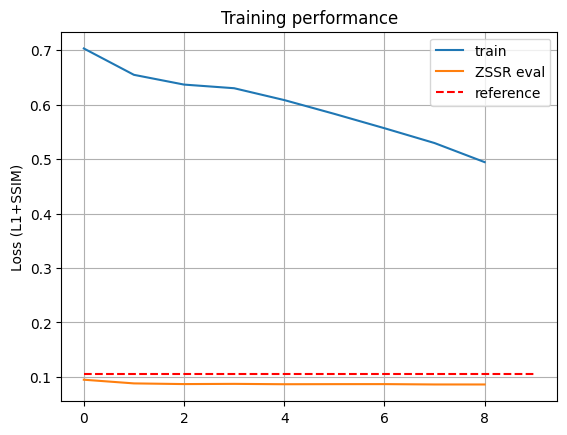

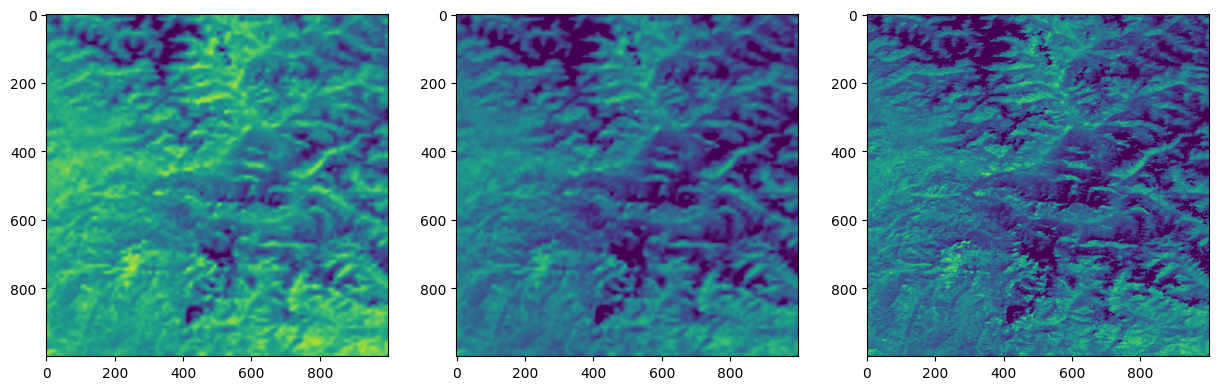

In [ ]:
#UP_SCALE = 10 NUM_ITER = 50 # 200 LEARN_RATE = 1e-3 CROP_SIZE = 100 BATCH_SIZE = 4
CUDA_LAUNCH_BLOCKING=1
UP_SCALE   = 10
NUM_ITER   = 1
LEARN_RATE = 1e-3
CROP_SIZE  = 100
BATCH_SIZE = 64
DL_ITEMS   = 500

mae  = torch.nn.L1Loss()
ssim = SSIMLoss().to(DEVICE)
psnr = PSNR().to(DEVICE)
loss_function = ZeroShotLoss().to(DEVICE)

filenameLR = "AG1km.v003.45.006.0010.h5"
filanameHR = "AG100.v003.45.006.0001.h5"
ground_truth = read_h5_temperature(filanameHR).unsqueeze(0).to(DEVICE)
img          = read_h5_temperature(filenameLR)
llim, ulim   = (img.mean()-3*img.std()).item(), (img.mean()+3*img.std()).item()

# initialise sampler
sampler = DataSamplerBatchHF(img, UP_SCALE, CROP_SIZE, BATCH_SIZE, crop_only=True)

model  = ZSSRNet(input_channels=2, out_channels=1, kernel_size=3, channels=64, ndepth=14).to(DEVICE)
#model = MRUNet(n_channels=2, n_outchannels=1, n_resblocks=4).to(DEVICE)

#history = train(model, img, ground_truth, sampler,
#                sr_factor=UP_SCALE,
#                num_iter=NUM_ITER,
#                learning_rate=LEARN_RATE,
#                crop_size=CROP_SIZE,
#                batch_size=BATCH_SIZE,
#                reduce_epoch=int(NUM_ITER*0.75),
#                reduce_sf=0.1)
history = train_prog(model, img, ground_truth, sampler,
                sr_factor=UP_SCALE,
                num_iter=NUM_ITER,
                num_items=DL_ITEMS,
                learning_rate=LEARN_RATE,
                crop_size=CROP_SIZE,
                batch_size=BATCH_SIZE,
                reduce_epoch=int(NUM_ITER*0.75),
                reduce_sf=0.1)

srimg, img_up  = test(model, sampler.img, sr_factor=UP_SCALE)
reference_loss = loss_function(img_up, ground_truth).detach().cpu().item()

# Print performance
print(f"""Bicubic - Loss: {loss_function(img_up, ground_truth):.6f},
                    MAE: {mae(img_up, ground_truth):.6f},
                    PSNR: {-psnr(img_up, ground_truth):.6f},
                    SSIM: {1-ssim(img_up, ground_truth):.6f}""")
print(f"""   ZSSR - Loss: {loss_function(srimg, ground_truth):.6f},
                    MAE: {mae(srimg, ground_truth):.6f},
                    PSNR: {-psnr(srimg, ground_truth):.6f},
                    SSIM: {1-ssim(srimg, ground_truth):.6f}""")

# Plot
plt.plot(history["train"], label="train");
plt.plot(history["eval"],  label="ZSSR eval");
plt.hlines(reference_loss, 0, len(history["train"]), colors="red", linestyle="dashed", label="reference")
plt.title("Training performance"); plt.ylabel("Loss (L1+SSIM)");
plt.legend(); plt.grid(); plt.show()
_, axs = plt.subplots(1, 3, figsize=(15, 10))
for i,item in enumerate((img_up, srimg, ground_truth)):
    axs[i].imshow(item.cpu().squeeze(), vmin=llim, vmax=ulim)
plt.show()

# HFGN module



### Reference implementation
As in Liu et al., 2024 (https://doi.org/10.1016/j.engappai.2024.109336)


In [45]:
class HFCrossAttention(nn.Module):
    def __init__(self, in_channel, hidden_dim=128):
        super(HFCrossAttention, self).__init__()
        self.hidden_dim  = hidden_dim
        # Learnable d parameter
        self.d = torch.nn.Parameter(
                torch.abs(torch.rand((1)) + torch.randint(10//2, 10*2, (1,))
                ))
        self.d.requires_grad=True

        # Convolutional encoder to process Q, K, V
        self.convHF = nn.Conv2d(1, hidden_dim, 3, 1, "same", bias=False)
        self.convK  = nn.Conv2d(in_channel, hidden_dim, 3, 1, "same", bias=False)
        self.convV  = nn.Conv2d(in_channel, hidden_dim, 3, 1, "same", bias=False)
        self.convA  = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding="same", bias=False)
        self.conv1  = nn.Conv2d(hidden_dim, in_channel, 1, bias=False)

    def forward(self, x, orig_hf):
        """ Args:
        x: (torch.Tensor) LR image of dim (b, c, h, w)
        orig_hf: (torch.Tensor) original High-Frequency map of dim (b, 1, h, w)
        """
        b, _, h, w = x.shape
        # tokens: with shape (batch, h*w, hdim)
        Q = self.convHF(orig_hf).view(b, h*w, self.hidden_dim)
        K = self.convK(x).view(b, h*w, self.hidden_dim)
        V = self.convV(x).view(b, h*w, self.hidden_dim)

        #scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # inner product of Q and K, a tensor
        # Channel-wise product
        scoremats = torch.einsum("bjk,bjc->bkc", Q, K)\
                    .view(b, 1, self.hidden_dim, self.hidden_dim)
        scoremats = self.convA(scoremats)\
                    .view(b, self.hidden_dim, self.hidden_dim)
        attnmats  = torch.nn.functional.softmax(scoremats / torch.sqrt(self.d), dim=-1)
        #ctx_vecs  = torch.einsum("BTS,BSH->BTH", attnmats, V)
        # To (batch, hdim, h, w)
        ctx_vecs  = torch.einsum("bkc,bij->bic", attnmats, V)\
                    .view(b, self.hidden_dim, h, w)
        # 1k conv to (batch, in_channel, h , w)
        ctx_vecs  = self.conv1(ctx_vecs)
        return x + ctx_vecs


class TransformerBlock(nn.Module):
    def __init__(self, in_channel, hidden_dim):# context_dim):
        super(TransformerBlock, self).__init__()
        self.cattn = HFCrossAttention(in_channel, hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.ReLU(), # GELU
            nn.Linear(3 * hidden_dim, hidden_dim),
        )

    def forward(self, x, orig_hf):
        """ Args:
        x: (torch.Tensor) LR image of dim (b, c, h, w)
        orig_hf: (torch.Tensor) original High-Frequency map of dim (b, 1, h, w)
        """
        x = self.cattn(self.norm1(x), orig_hf) + x
        x = self.ffn(self.norm2(x)) + x
        return x

class HFGModule(nn.Module):
    def __init__(self, in_channel, hidden_dim, nblocks):
        super(HFGModule, self).__init__()
        self.transblocks = nn.ModuleList(
            TransformerBlock(in_channel, hidden_dim) for _ in range(nblocks)
        )

    def forward(self, x, orig_hf):
        for block in self.transblocks:
            x = block(x, orig_hf)
        return x

"""
class SpatialTransformer(nn.Module):
    def __init__(self, in_channel, hidden_dim):
        super(SpatialTransformer, self).__init__()
        self.transformer = TransformerBlock(in_channel, hidden_dim)

    def forward(self, x, orig_hf):# context=None):
        b, c, h, w = x.shape
        x_in = x
        # Combine the spatial dimensions and move the channel dimen to the end
        x = rearrange(x, "b c h w->b (h w) c")
        # Apply the sequence transformer
        x = self.transformer(x, orig_hf)
        # Reverse the process
        x = rearrange(x, "b (h w) c -> b c h w", h=h, w=w)
        # Residue
        return x + x_in
"""

# Test
in_channel = 4
hidden_dim = 64
ca = HFCrossAttention(in_channel, hidden_dim)
tr = TransformerBlock(in_channel, hidden_dim)
st = HFGModule(in_channel, hidden_dim, nblocks=4)

x       = torch.rand((4, in_channel, 64, 64))
orig_hf = torch.rand((4, 1, 64, 64))

out = ca(x,orig_hf)
out2 = tr(x, orig_hf)
out3 = st(x, orig_hf)

#norm = nn.LayerNorm(hidden_dim)
#print(norm(x).shape)
print("CrossAtt output", out.shape)
print("Tblock", out2.shape)
print("tansformers", out3.shape)
print(st)
print(f"Learnable params: {sum(p.numel() for p in st.parameters() if p.requires_grad)}")


CrossAtt output torch.Size([4, 4, 64, 64])
Tblock torch.Size([4, 4, 64, 64])
tansformers torch.Size([4, 4, 64, 64])
HFGModule(
  (transblocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (cattn): HFCrossAttention(
        (convHF): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (convK): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (convV): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (convA): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (conv1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=64, out_features=192, bias=True)
        (1): ReLU()
        (2): Linear(in_features=192, out_features=64, bias=True)
      )
    )

In [55]:
class ResBlock(nn.Module):
    def __init__(self, nchannels, ndepth):
        super().__init__()
        self.ndepth = ndepth
        self.act = nn.SiLU()
        self.res_conv_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same", bias=False),
                nn.BatchNorm2d(nchannels),
                nn.SiLU(),
                nn.Conv2d(nchannels, nchannels, 3, stride=1, padding="same", bias=False),
                nn.BatchNorm2d(nchannels),
                )
            for _ in range(self.ndepth)])

    def forward(self, x):
        for conv_block in self.res_conv_blocks:
            x = self.act(conv_block(x) + x)
        return x


class HFGNet(nn.Module):
    def __init__(self, input_channels, nchannels=32, ndepth=4, nblocks=1):
        """
        nchannels: (int) hidden dimension for HFGmodule and z
        """
        super().__init__()
        self.resblock1 = ResBlock(input_channels, ndepth)
        self.conv1     = nn.Conv2d(input_channels, nchannels, kernel_size=1, bias=False)
        self.maxpool   = nn.MaxPool2d(kernel_size=2, stride=2)
        self.resblock2 = ResBlock(nchannels, ndepth)
        self.deconv    = nn.ConvTranspose2d(nchannels, nchannels, kernel_size=3, stride=2,
                                       padding=1, output_padding=1)
        self.outconv = nn.Conv2d(nchannels, 1, kernel_size=3, padding="same", bias=False)

        self.hfgmodule = HFGModule(in_channel, nchannels, nblocks)

    def forward(self, x):
        orig = x[:, 0, :, :].unsqueeze(1).clone()
        hf   = x[:, 1, :, :].unsqueeze(1).clone()

        x = self.resblock1(orig)
        x = self.conv1(x)
        hf_skip = self.hfgmodule(x, hf)
        x = self.maxpool(x)
        x = self.resblock2(x)
        x = self.deconv(x)
        x = self.outconv(x + hf_skip)
        return x + orig


x = torch.rand((1,2,64,64))
net = HFGNet(input_channels=1, nchannels=16, ndepth=2, nblocks=1)

print(f"Learnable params: {sum(p.numel() for p in net.parameters() if p.requires_grad)}")

print(net(x).shape)

# layer norm expect sequence like [*, 16 ] dimension not image of 16 channels (need to flatten)


Learnable params: 14902


RuntimeError: Given normalized_shape=[16], expected input with shape [*, 16], but got input of size[1, 16, 64, 64]